In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Desbalanceamento de Dados

## Por que desbalanceamento é uma questão?

1) Problemas para definição e mensuração dos problemas.

2) Complicações na separabilidade das classes.

3) Diversas funções de custo consideram dados balanceados.

# 1) Definição e Mensuração

 Quais abordagens comuns para resolução?
    
## 1) Uso de métricas robustas
- É bastante comum o uso de métricas de avaliação que sejam robustas, como o AUC, que é mais invariante a diferentes niveis de desbalanceamento do que outras métricas.

- Essa abordagem é reutilizavel, fornecendo métricas que são diretamente interpretaveis mesmo ao ser aplicadas em problemas diferentes.

- Essa abordagem em geral não incorpora a informação de diferentes custos dentro da classe minoritaria, o que pode fazer com que modelos subótimos tenham "melhor performance" do que outras abordagens mais eficientes.

- Exemplos dessa situação são modelos com alta precisão em observações de baixo valor da classe majoritária, mas com precisão péssima nas observações mais relevantes.

## 2) Construção de métricas especificas
- Essa abordagem tem a vantagem de apresentar intepretabilidade mais granular e próxima dos custos reais do problema, pensando no uso do modelo para tomada de decisões.

- Exige maior dispendio de tempo, maior conhecimento teórico e complexidade técnica para sua elaboração, do que a utilização de métricas robustas.

- Sua estruturação não é reutilizavel, sendo necessário estabelecer uma nova métrica de avaliação para cada nova situação e tornando necessário novo alinhamento de como interpertar a métrica.

## 3) Redefinição do problema.

- Outra abordagem possivel é buscar transformar o problema em uma situação mais simples, redefinindo publico alvo e target da situação.

- A forma mais comum é focar em um subconjunto dos dados menos afetado pelo desbalanceamento mas que mantenha interesse de solução, dado que esse subconjunto possa ser facilmente identificado.

- Um exemplo seria uma doença rara, mas que acomete mais pessoas de maior idade, e alteração do publico alvo apenas para idosos. Ou então alteração de publico em um problema de Churn, quando uma parte significativa da volumetria se concentra em clientes novos, com menor volumetria.

- Outra estrategia é agrupar casos similares, para tratar eles de forma conjunta e simplificar a situação (ex: sem tumor, tumor benigno, tumor maligno; no lugar de gravidade numérica medida para cada tumor) 

- Nesse caso, pode ocorrer que não existam critérios tão óbvios e objetivos para agrupamento das observações. 

- Um ponto de atenção é que essas abordagens simplificadas não são equivalentes as situações originais, o que implica em perda de volumetrias, granularidades nos resultados e outras desconsideração de questões que podem ter impacto prático. 


# 2) Separabilidade das classes.
    
 A definição de uma fronteira de decisão é um ponto fundamental para realizar a separações entre as classes de um problema.

Quando temos uma classe com baixissima ocorrencia frente a outra, dois fenomenos importantes podem impactar a estimação da fronteira de decisão

## 1) Poucas observações das classes minoritarias dificultam identificar suas regiões do espaço.2) A classe majoritaria pode "contaminar" a região do espaço ocupada pelas classes minoritarias. Exemplo

#### Caso 1)
- É possivel observar que vai se tornando mais dificil definir uma boa fronteira de decisão conforme reduzimos as observações da classe minoritaria.

- Nesse exemplo, estamos observando uma situação em 2 dimensões, porem um destaque importante é que mesmo sem o problema de desbalanceamento, a definição de uma fronteira de decisão já é dificultada pela maldição da dimensionalidade. Isso implica que os dois problemas existem conjuntamente.

#### Caso 2)
- É comum que existam diferentes regiões do espaço, com probabilidade muito maior ou menor de encontrarmos observações de cada uma das classes.

- Conforme aumentamos a quantidade total de amostras de uma classe , todas essas diferentes regiões tem um aumento de densidade, ou seja, passam a conter mais pontos.

- Isso implica que algumas regiões, com baixa probabilidade mas que compartilham o espaço com a classe minoritária, passam a ser populadas incrementalmente pela classe majoritária, "ocultando" as observações minoritárias presentes nessas regiões.   
 

In [2]:
def ExemploProblemaSeparabilidade(quantidade_majoritaria, quantidade_minoritaria):
    
    def gauss_2d(mu, sigma, target):
        x = np.random.normal(mu, sigma)
        y = np.random.normal(mu, sigma)
        return (x, y, target)

    distribuicao_classe_0 = pd.DataFrame([gauss_2d(0, 3, 0) for i in range(0, quantidade_majoritaria)], columns = ['var1', 'var2', 'target'])
    distribuicao_classe_1 = pd.DataFrame([gauss_2d(10, 2.5, 1) for i in range(0, quantidade_minoritaria)], columns = ['var1', 'var2', 'target'])

    df_todas_classes = pd.concat([distribuicao_classe_0, distribuicao_classe_1])

    return df_todas_classes

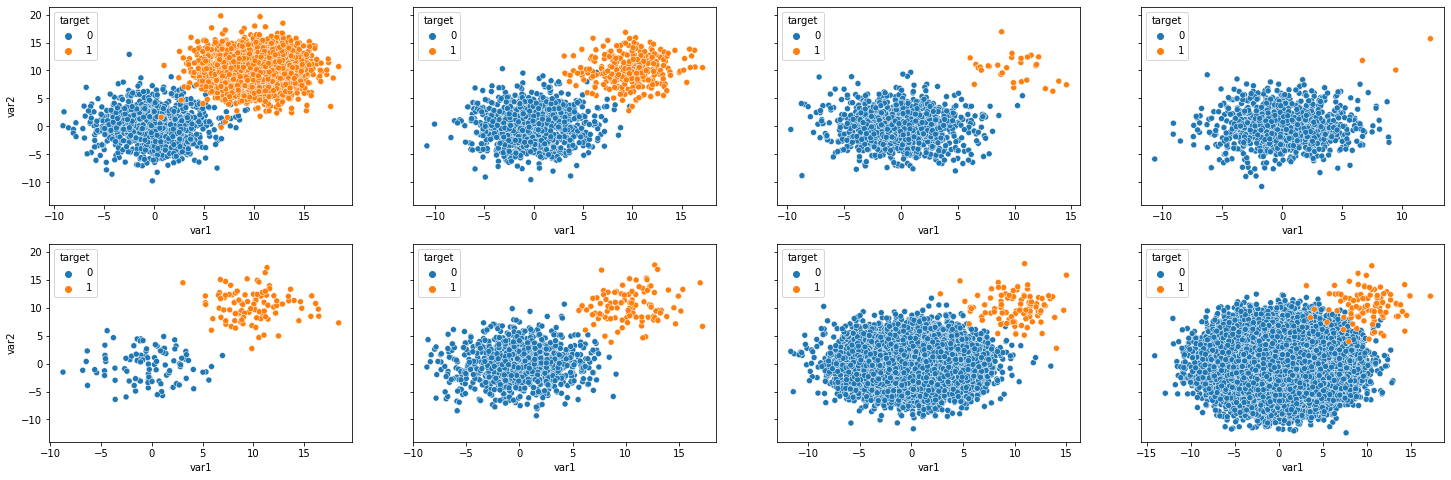

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(25, 8), sharey=True)

for i in range(0, 4):
        
        df_poucas_obs = ExemploProblemaSeparabilidade(1000, 3 * (10 ** i))
        df_contaminacao = ExemploProblemaSeparabilidade(100 * (10 ** i), 100)
        
        sns.scatterplot(x = df_poucas_obs['var1'], y = df_poucas_obs['var2'], hue = df_poucas_obs['target'], ax = axes[0, 3 - i]);
        sns.scatterplot(x = df_contaminacao['var1'], y = df_contaminacao['var2'], hue = df_contaminacao['target'], ax = axes[1, i]);  

# Quais abordagens comuns para resolução?

## 1) Abordagens por amostragem (Undersampling e OverSampling)

- O principio das abordagens por amostragem se voltam para; 1) Diminuir a contaminação da classe majoritária na classe minoritária, ao diminuir a quantidade de observações majoritárias utilizadas; e 2) Aumentar a quantidade de amostras presentes da classe minoritária, de forma a facilitar definir sua região do espaço

- Uma vantagem muito grande dessas abordagens é que elas são Agnosticas em relação aos Modelos, ou seja, podem ser feitas nos dados de maneira independente aos modelos que serão utilizados nas observações.

- Outra vantagem é a simplicidade e facilidade com que as abordagens de amostragem conseguem ser feitas, o que não aumenta muito a complexidade geral dos projetos.

- Um ponto de atenção importante é que essas abordagens costumam poder ser realizadas de diversas maneiras diferentes, não resolvendo magicamente o problema, dependendo de alguns pontos principais na forma feita, podem inclusive piorar a situação anterior se não forem bem feitas.

## 2) Ensembles

- A ideia aqui é a combinação de modelos, usando critérios especificos, de maneira com que o problema da separabilidade seja resolvido pelo conjunto dos modelos combinados.

- Muitas vezes, consegue utilizar melhor as informações contidas nos dados originais do que as abordagens de amostragem.

- Costumam ser simples de serem feitas, porem adicionam uma camada extra de complexidade ao ser necessário combinar diversos modelos para obter o resultado.

- Em geral, as técnicas costumam poder ser aplicadas em diferentes tipos de modelos, porem é necessário mais ajustes do que nas abordagens por amostragem.

## 3) Alterações nos algoritmos.
- A abordagem mais complexa de todas indicadas acima, pois envolve mexer diretamente na forma de implementação de cada um dos modelos utilizados

- Todas as alterações são dependentes do modelo, ou seja, ao serem realizadas em um tipo de modelo, não podem ser reaplicadas em modelos de outros tipos.

- Tem a vantagem de manter a complexidade de apenas um modelo para solução, sem realizar nenhuma alteração na distribuição realmente existente dos dados pelas metodologias de amostragem, assim como sem adicionar camadas de complexidade adicionais por ensembles.
     

#  3) Funções de custo

 Funções de custo
 
- Geralmente é estabelecido alguma dinamica interna nos algoritmos de Aprendizagem Estátistica / Machine Learning para que eles "aprendam" com as informações repassadas.

- Essa dinamica interna costuma ser constituida por alguma função de custo, que é uma função que mensura internamente a performance do modelo, e alguma metodologia para atualização dos parametros, de maneira a melhorar a performance mensurada pela função de custo.


- Exemplos de funções de custo é o Minimo Erro Quadrado para regressões lineares, Gini/Entropia para Arvores de decisão e LogLoss para Regressões Logisticas

- Tirando o caso do Minimos Erros Quadraticos, é pouco comum que funções de custo sejam escolhidas como métricas de avaliação de algoritmos; assim como métricas mais comuns de avaliações sejam escolhidas para serem funções de custo. 

- O motivo disso é que as funções de custo costumam ser escolhidas por serem faceis/rapidas de serem calculadas e por existir alguma garantia de convergencia da atualização dos parametros para um ponto ótimo, mas não costumam ter boa interpretabilidade para tomadas de decisão.

- Já as métricas de avaliação mais comumente utilizadas (accuracy, precision, recall, auc, ks, etc) costumam apresentar maior interpretabilidade para tomada de decisão e avaliação do algoritmo, porem não costumam apresentar garantias de convergencia ao usadas como função de custo ou são excessivamente custosas computacionalmente para serem usadas dessa maneira.

- Dado esses pontos acima e a discussão sobre mensuração de problemas desbalanceadas, é bastante comum que as funções de custo tradicionais em que os algoritmos foram implantados sejam sensiveis a desbalanceamentos, ou seja, sejam afetadas negativamente em algum aspecto.

- No caso das arvores de decisão em problemas desbalanceados, é possivel que splits com pior separabilidade entre as classes sejam escolhidos, por apresentarem melhor Gini/Entropia, ou seja, algumas quebras piores serem escolhidas frente a outras melhores disponiveis.

- Já no caso da regressão lógistica, o desbalanceamento impacta a função de custo de forma que as probabilidades estimadas para classe minoritária possam ficar extremamente descalibradas, mesmo quando existe separabilidade linear entre as classes.



# Quais abordagens comuns para resolução?

## 1) Abordagens por amostragem (Undersampling e OverSampling)

- Pontos já discutidos 

## 2) Alterações nas funções de custo dos algoritmos.

- Abordagem é bastante complexa de ser implementada, exigindo profundo conhecimento de programação/matemática para começar a ser realizada.

- Exige muito mais tempo para ser realizado.

- Não é independente do algoritmo, ou seja, não pode ser reaplicado em diferentes algoritmos após ser realizada.


In [4]:
def ExemploProblemaFuncaoCusto(quantidade_majoritaria, quantidade_minoritaria):
    
    def gauss_2d(mu, sigma, target):
        x = np.random.normal(mu, sigma)
        y = np.random.normal(mu, sigma)
        return (x, y, target)

    distribuicao_classe_0 = pd.DataFrame([gauss_2d(0, 3, 0) for i in range(0, quantidade_majoritaria)], columns = ['var1', 'var2', 'target'])
    distribuicao_classe_1 = pd.DataFrame([gauss_2d(10, 3, 1) for i in range(0, quantidade_minoritaria)], columns = ['var1', 'var2', 'target'])

    df_todas_classes = pd.concat([distribuicao_classe_0, distribuicao_classe_1])

    return df_todas_classes

## Proporção Classe Minoritária X Classe Majoritária

### 1) 5 / 1000

{1000: 0.9740216439327424,
 1001: 0.9994221537002043,
 1002: 0.8734010499723598,
 1003: 0.9805289171813769,
 1004: 0.9910282855352309}

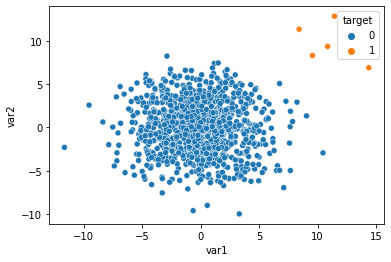

In [5]:
df_funcao_custo = ExemploProblemaFuncaoCusto(1000, 5)

sns.scatterplot(x = df_funcao_custo['var1'], y = df_funcao_custo['var2'], hue = df_funcao_custo['target']);


from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression()

lreg.fit(df_funcao_custo[['var1', 'var2']], df_funcao_custo['target'])

y_predicted = pd.Series(lreg.predict(df_funcao_custo[['var1', 'var2']]))
y_predicted_proba = pd.DataFrame(lreg.predict_proba(df_funcao_custo[['var1', 'var2']]))[1]

y_predicted_proba.tail().to_dict()

###  2) 5 / 10000

{10000: 0.7554439729362017,
 10001: 0.5395892172382932,
 10002: 0.9970735795456773,
 10003: 0.9992969240891248,
 10004: 0.9999850213179908}

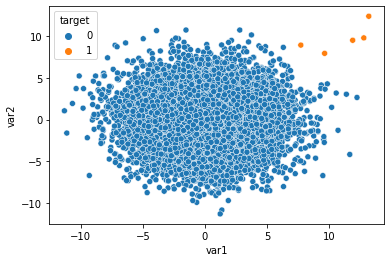

In [6]:
df_funcao_custo = ExemploProblemaFuncaoCusto(10000, 5)

sns.scatterplot(x = df_funcao_custo['var1'], y = df_funcao_custo['var2'], hue = df_funcao_custo['target']);


from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression()

lreg.fit(df_funcao_custo[['var1', 'var2']], df_funcao_custo['target'])

y_predicted = pd.Series(lreg.predict(df_funcao_custo[['var1', 'var2']]))
y_predicted_proba = pd.DataFrame(lreg.predict_proba(df_funcao_custo[['var1', 'var2']]))[1]

y_predicted_proba.tail().to_dict()

###  3) 5 / 100000

{100000: 0.9015134136488464,
 100001: 0.25249011201348803,
 100002: 0.009715895657494832,
 100003: 0.7277185519584375,
 100004: 0.9935229995685505}

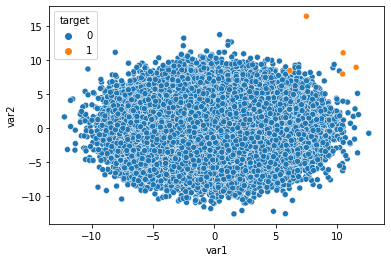

In [7]:
df_funcao_custo = ExemploProblemaFuncaoCusto(100000, 5)

sns.scatterplot(x = df_funcao_custo['var1'], y = df_funcao_custo['var2'], hue = df_funcao_custo['target']);


from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression()

lreg.fit(df_funcao_custo[['var1', 'var2']], df_funcao_custo['target'])

y_predicted = pd.Series(lreg.predict(df_funcao_custo[['var1', 'var2']]))
y_predicted_proba = pd.DataFrame(lreg.predict_proba(df_funcao_custo[['var1', 'var2']]))[1]

y_predicted_proba.tail().to_dict()

#  Técnicas de Amostragem

## Por que as técnicas de amostragem (undersampling e oversampling) costumam ser as mais conhecidas e utilizadas?

- Simplicidade.
- Facilidade.
- Relativamente agnostico.
- Possivel realizar de maneira modularizada, ou seja, independentemente do restante do pipeline e de modelo escolhido.

## Quais são os problemas envolvidos nessas técnicas?

#### 1) Se assume que essas abordagens são equivalentes as outras, porem não são.

#### 2) Problema de UnderSampling

- Joga fora observações que possivelmente são importantes para diferenciação entre as classes.

#### 3) Problema do OverSampling

- Por aumentar a quantidade de dados, aumenta a complexidade computacional para treinar o modelo.

- Consegue apenas construir uma aproximação da distribuição original da classe minoritaria, não correspondendo com a distribuição verdadeira

- Dependendo da forma, utiliza pressupostos diferentes que podem estar sendo violados (outliers/discretização/categoricas/proximidade com a fronteira de decisão)

##  Porque random Over e Under é um lixo?


- As técnicas de Random Over e Under sampling apresentam um deficiencia fundamental. Elas não utilizam nenhum critério para seleção das amostras removidas ou adicionadas.

# Random UnderSampling

- Nesse caso, isso significa que nenhum critério é aplicado para diferenciar entre amostras removidas - que podem ser tanto observações importantes para diferenciação entre as duas classes, observações muito distantes das fronteiras de decisão e que impactarão pouco no resultado ou então amostras que, de fato, contaminam a região do espaço ocupado pelas classes minoritarias.


# Random OverSampling

- Nesse caso, são geradas diversas cópias da observações já existentes, sem nenhum critério para isso. Isso não implica que a região do espaço da classe minoritaria passou a ser melhor identificada, as observações copiadas podem estar longe da fronteira de decisão ou serem observações pouco representativas/ruidosas, prejudicando a classicação.

 

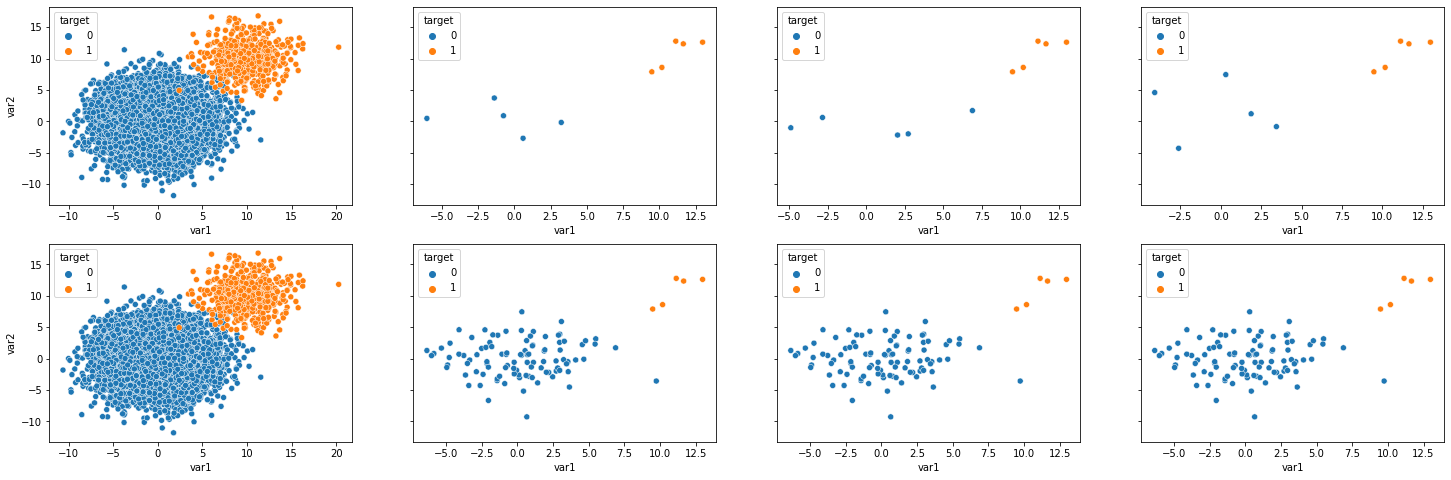

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(25, 8), sharey=True)

df_distro_real = ExemploProblemaSeparabilidade(10000, 500)

sns.scatterplot(x = df_distro_real['var1'], y = df_distro_real['var2'], hue = df_distro_real['target'], ax = axes[0,0])
sns.scatterplot(x = df_distro_real['var1'], y = df_distro_real['var2'], hue = df_distro_real['target'], ax = axes[1,0])


###########

df = ExemploProblemaSeparabilidade(100, 5)


for i in range(1, 4):
    
    classe0_under = df.iloc[:-5].sample(n = 5)
    classe1 = df.iloc[-5:]
    df_undersampleado = pd.concat([classe0_under, classe1])

    sns.scatterplot(x = df_undersampleado['var1'], y= df_undersampleado['var2'], hue = df_undersampleado['target'], ax = axes[0, i]);
    sns.scatterplot(x = df['var1'], y= df['var2'], hue = df['target'], ax = axes[1, i]);

## Padrão na literatura de artigos produzidos sobre técnicas de amostragem para desbalanceamento


- Oversampling costuma ter vantagem significa de performance sobre undersampling.

- Quando testadas conjuntamente, um mix de OverSampling + Undersampling costuma obter melhor performance do que OverSampling puro.

## Oversampling

SMOTE surgiu rapidamente na literatura como uma das formas mais eficientes de amostragem, gerando diversas variações voltadas para superar suas variações.- Como Funciona?
Gera novas amostras a partir de extrapolação das antigas.

Os passos são os seguintes: 

1) O algoritmo seleciona aleatoriamente uma observação.

2) A partir dessa observação, encontra seus K vizinhos mais próximos (geralmente 5).

3) Traça uma reta entre a primeira entre a primeira observação e cada um de seus K vizinhos.

4) Em cada uma das K retas geradas, um ponto aleatório é selecionado e uma nova observação é gerada.

5) Esse procedimento ocorre até o balanceamento **ou** outro critério de parada.
- Quais os hyperparametros?
1) Quantidade de K vizinhos escolhidos.

2) Critério de parada.
- Quais os pressupostos?
1) Todas as variaveis são numéricas e continuas

2) A distribuição da classe é convexa.

3) É relativamente sensivel a outliers e amostras ruidosas da classe minoritária - relativamente devido a impacto de hyperparametros.

4) Pode dar problema se classe for gerada por diversas distribuições, não interseccionais.
 Exem

# Exemplo - Variando K Vizinhos e Variando Critério de Parada


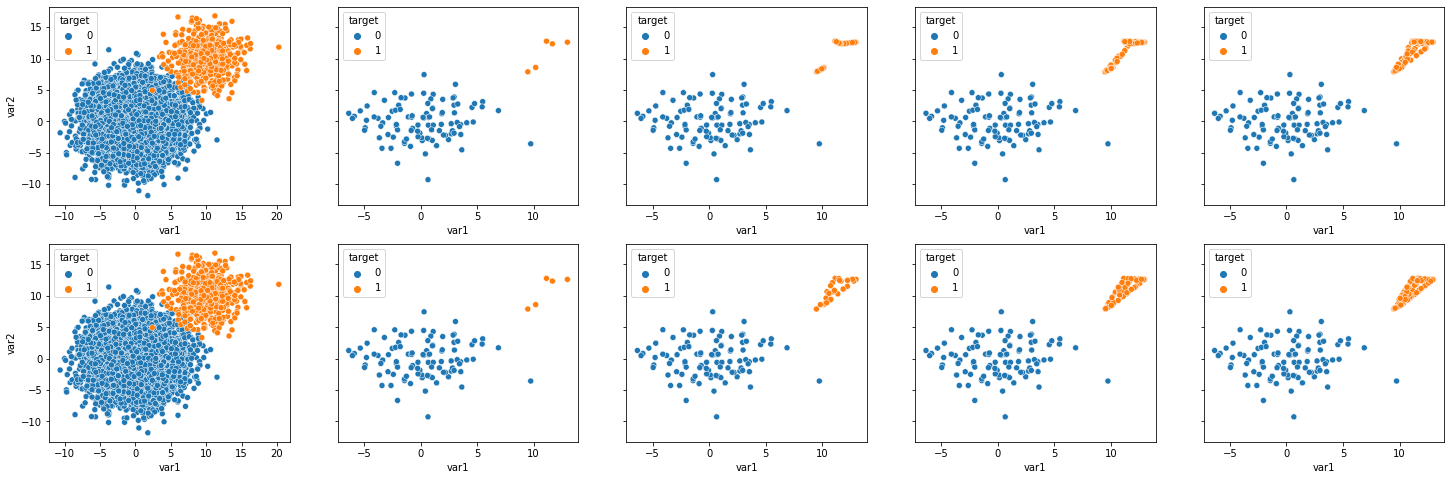

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(25, 8), sharey=True)

sns.scatterplot(x = df_distro_real['var1'], y = df_distro_real['var2'], hue = df_distro_real['target'], ax = axes[0, 0])
sns.scatterplot(x = df_distro_real['var1'], y = df_distro_real['var2'], hue = df_distro_real['target'], ax = axes[1, 0])


sns.scatterplot(x = df['var1'], y = df['var2'], hue = df['target'], ax = axes[0, 1])
sns.scatterplot(x = df['var1'], y = df['var2'], hue = df['target'], ax = axes[1, 1])

###########

for i in range(2, 5):
    
    sm = SMOTE(random_state = 42, k_neighbors = i - 1)
    X_res, y_res = sm.fit_resample(df[['var1', 'var2']], df['target'])
    
    sm2 = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = 1 / (5 - i))
    X_res2, y_res2 = sm2.fit_resample(df[['var1', 'var2']], df['target'])    
    
    sns.scatterplot(x = X_res['var1'], y = X_res['var2'], hue = y_res.apply(lambda a : int(a)), ax = axes[0, i]);
    sns.scatterplot(x = X_res2['var1'], y = X_res2['var2'], hue = y_res2.apply(lambda a : int(a)), ax = axes[1, i]);

# Exemplo - Outlier

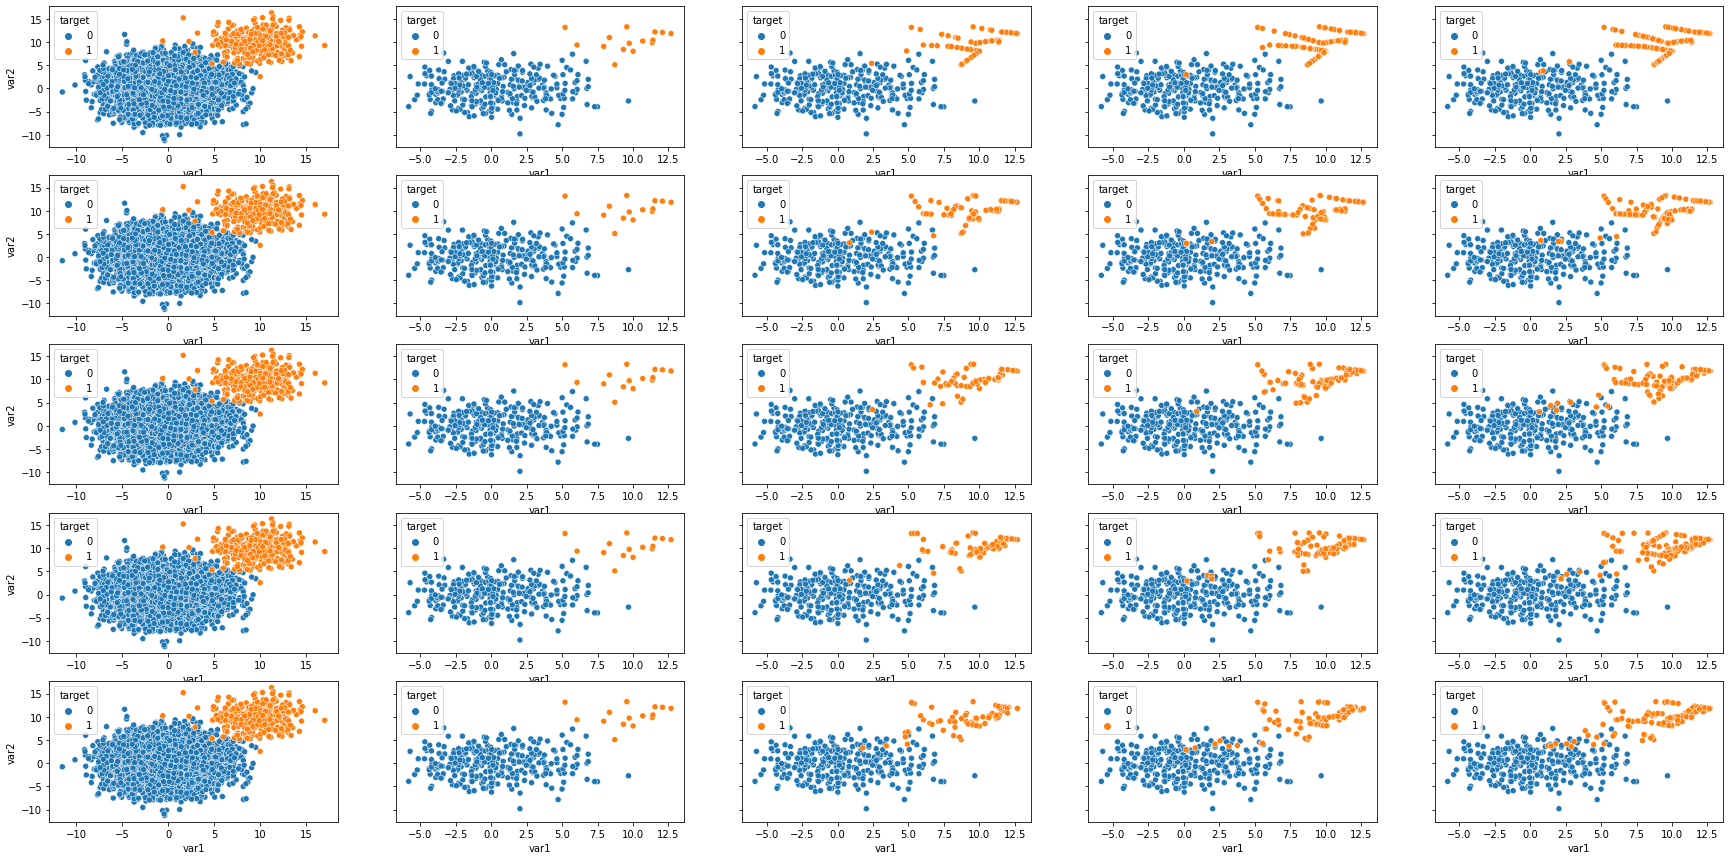

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(30, 15), sharey=True)

dfzao = ExemploProblemaSeparabilidade(300, 15)
indice_outlier = dfzao.query('target == 0').sample(n = 1).index
dfzao.loc[indice_outlier, 'target'] = 1

dfzao2 = ExemploProblemaSeparabilidade(6000, 300)

sns.scatterplot(x = dfzao2['var1'], y = dfzao2['var2'], hue = dfzao2['target'], ax = axes[0, 0]);
sns.scatterplot(x = dfzao2['var1'], y = dfzao2['var2'], hue = dfzao2['target'], ax = axes[1, 0]);
sns.scatterplot(x = dfzao2['var1'], y = dfzao2['var2'], hue = dfzao2['target'], ax = axes[2, 0]);
sns.scatterplot(x = dfzao2['var1'], y = dfzao2['var2'], hue = dfzao2['target'], ax = axes[3, 0]);
sns.scatterplot(x = dfzao2['var1'], y = dfzao2['var2'], hue = dfzao2['target'], ax = axes[4, 0]);


for k in range(0, 4):

    for i in range(0, 5):

        if k == 0:

            sns.scatterplot(x = dfzao['var1'], y = dfzao['var2'], hue = dfzao['target'], ax = axes[i, k + 1]);
            
        else:
            
            sm = SMOTE(random_state = 42, k_neighbors = i + 1, sampling_strategy = 1 / (5 - k))
            X_res, y_res = sm.fit_resample(dfzao[['var1', 'var2']], dfzao['target'])

            sns.scatterplot(x = X_res['var1'], y = X_res['var2'], hue = y_res.apply(lambda a : int(a)), ax = axes[i, k + 1]);  

### Métodos Popularizados e Mais Interessantes de UnderSampling

- K Near Miss
- Tomek Links
- Edited Nearest Neighbours